In [1]:
import h5py, sys, os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
from scipy.interpolate import griddata
print(os.getcwd())

%matplotlib widget

from jfunctions import *

# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

/mhome/damtp/q/cwp29/diablo3/proc/jupyter


In [2]:
#Load simulation data
b, phi_v, phi_c, u, v, w, times = load_data('th1_xz', 'th2_xz', 'th3_xz', 'u_xz', 'v_xz', 'w_xz')
NSAMP = len(times)

times, t0_idx = calibrate_time(save_dir, times)

b_az, w_az, phiv_az, phic_az = load_az_data('b_az', 'w_az', 'phiv_az', 'phic_az')

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

Keys: <KeysViewHDF5 ['B_xy', 'B_xz', 'B_yz', 'Ent_phic_flux_int', 'Ent_phic_flux_rec', 'Ent_phip_flux_int', 'Ent_phip_flux_rec', 'Ent_phiv_flux_int', 'Ent_phiv_flux_rec', 'N2_xy', 'N2_xz', 'N2_yz', 'Re_b_xy', 'Re_b_xz', 'Re_b_yz', 'Ri_xy', 'Ri_xz', 'Ri_yz', 'b_phic_F1', 'b_phic_F3', 'b_phic_Jc', 'b_phic_K', 'b_phic_M', 'b_phic_S', 'b_phic_W', 'b_phip_F1', 'b_phip_F4', 'b_phip_M', 'b_phip_S', 'b_phip_W', 'b_phiv_F1', 'b_phiv_F2', 'b_phiv_Jv', 'b_phiv_M', 'b_phiv_S', 'b_phiv_W', 'chi1_xy', 'chi1_xz', 'chi1_yz', 'chi2_xy', 'chi2_xz', 'chi2_yz', 'chi3_xy', 'chi3_xz', 'chi3_yz', 'chi4_xy', 'chi4_xz', 'chi4_yz', 'diff_th1_xy', 'diff_th1_xz', 'diff_th1_yz', 'diff_th2_xy', 'diff_th2_xz', 'diff_th2_yz', 'diff_th3_xy', 'diff_th3_xz', 'diff_th3_yz', 'diff_th4_xy', 'diff_th4_xz', 'diff_th4_yz', 'epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'kappa_t3_xy', 'kappa_t3_xz', 'kappa_t3_yz', 'kappa_t4_xy', 'kappa_t4_xz',

In [3]:
print(md)

{'LX': 0.6, 'LY': 0.6, 'LZ': 0.6, 'RE': 10000000000.0, 'nu': 1e-10, 'SAVE_MOVIE_DT': 0.25, 'SAVE_STATS_DT': 0.25, 'NU_START': 1e-09, 'SAVE_FLOW_DT': 5.0, 'VERSION': 3.12, 'NU_START_TIME': 15.0, 'r0': 0.002, 'alpha_e': 0.11, 'b0': 0.02, 'Lyc': 0.02, 'Lyp': 0.01, 'S_depth': 0.2, 'N2': 1.0, 'H': 0.2, 'b_factor': 0.25, 'phiv_factor': 0.4, 'phic_factor': 3.0, 'Nb': 128.0, 'Nphi': 128.0, 'F_TYPE': 3.0, 'phi0': 0.03, 'alpha': 67.0, 'beta': 0.51, 'tau': 0.1, 'q0': 0.5, 'phiv_min': 0.0002, 'phic_min': 0.0002, 'T': 10.0, 'Trelax': 0.5, 'w_s': 0.01, 'INIT_NOISE': 1e-08, 'shear_rate': 0.2, 'Nx': 256, 'Ny': 256, 'Nz': 257, 'Nth': 4}


In [4]:
#Create grid
X, Y = np.meshgrid(gx, gz)
Xf, Yf = np.meshgrid(gxf, gzf)

r_0 = md['r0']
dr = md['LX']/md['Nx']
nbins = int(md['Nx']/2)
r_bins = np.array([r*dr for r in range(0, nbins+1)])
r_points = np.array([0.5*(r_bins[i]+r_bins[i+1]) for i in range(nbins)])

Xa, Ya = np.meshgrid(r_bins, gz)
Xaf, Yaf = np.meshgrid(r_points, gzf)

print("Total time steps: %s"%NSAMP)
print("Dimensional times: ",times)


Total time steps: 60
Dimensional times:  [-4.72163468 -4.47163468 -4.22163468 -3.97163468 -3.72163468 -3.47163468
 -3.22163468 -2.97163468 -2.72163468 -2.47163468 -2.22163468 -1.97163468
 -1.72163468 -1.47163468 -1.22163468 -0.97163468 -0.72163468 -0.47163468
 -0.22163468  0.          0.25        0.5         0.75        1.
  1.25        1.5         1.75        2.          2.25        2.5
  2.75        3.          3.25        3.5         3.75        4.
  4.25        4.5         4.75        5.          5.25        5.5
  5.75        6.          6.25        6.5         6.75        7.
  7.25        7.5         7.75        8.          8.25        8.5
  8.75        9.          9.25        9.5         9.75       10.        ]


In [5]:
# Environmental variables

alpha = md['alpha']
beta = md['beta']
q_0 = md['q0']
T0 = 300 # K

b_env = md['N2'] * (Yf - md['H'])
b_env[gzf < md['H']] = 0

b_az_env = md['N2'] * (Yaf - md['H'])
b_az_env[gzf < md['H']] = 0

T_env = 1340 * (b_env - beta * Yf)

phi_sat = q_0 * np.exp(alpha/1340 * T_env)

T = 1340 * (b - beta * Yf) + T0 - 273.15
theta = 1340 * b + T0

# Relative humidity
r = phi_v/phi_sat

# Total water
phi_t = phi_v + phi_c

In [6]:
# Set up

contours_b = np.linspace(10, 150, 15) + T0
fn = 8
fnc = 1

steps = [t0_idx+16, t0_idx+32, len(times)-1]

xstart = get_index(0.2, gxf)-1
xend = get_index(0.4, gxf)+1
zstart = get_index(0.9*md['H'], gzf)-1
zend = get_index(1.5*md['H'], gzf)+1

Xfc, Yfc = np.meshgrid(gxf[xstart:xend], gzf[zstart:zend])
Xfi, Yfi = np.meshgrid(gxf[xstart:xend], np.linspace(gzf[zstart], gzf[zend], zend-zstart))

uc = u[:, zstart:zend, xstart:xend]
wc = w[:, zstart:zend, xstart:xend]
ui = np.zeros_like(uc)
wi = np.zeros_like(wc)

for i in range(NSAMP):
    ui[i] = griddata((Xfc.flatten(), Yfc.flatten()), uc[i].flatten(), (Xfi, Yfi))
    wi[i] = griddata((Xfc.flatten(), Yfc.flatten()), wc[i].flatten(), (Xfi, Yfi))

/tmp/ipykernel_609268/3283001137.py:47: RuntimeWarning: Mean of empty slice
  ax[1].plot(np.nanmean(np.where(cloud == 1, w_az[steps[i]], np.nan), axis=1), gzf, color=c)
/tmp/ipykernel_609268/3283001137.py:48: RuntimeWarning: All-NaN slice encountered
  ax[1].plot(np.nanmax(np.where(cloud == 1, w_az[steps[i]], np.nan), axis=1), gzf, color=c)
/tmp/ipykernel_609268/3283001137.py:49: RuntimeWarning: All-NaN slice encountered
  ax[1].plot(np.nanmin(np.where(cloud == 1, w_az[steps[i]], np.nan), axis=1), gzf, color=c)
/tmp/ipykernel_609268/3283001137.py:51: RuntimeWarning: Mean of empty slice
  ax[2].plot(np.nanmean(np.where(cloud == 1, b_az[steps[i]]-b_az_env, np.nan), axis=1), gzf, color=c)
/tmp/ipykernel_609268/3283001137.py:53: RuntimeWarning: Mean of empty slice
  ax[3].plot(np.nanmean(np.where(cloud == 1, phiv_az[steps[i]], np.nan), axis=1), gzf, color=c)
/tmp/ipykernel_609268/3283001137.py:54: RuntimeWarning: Mean of empty slice
  ax[3].plot(np.nanmean(np.where(cloud == 1, phic_az[step

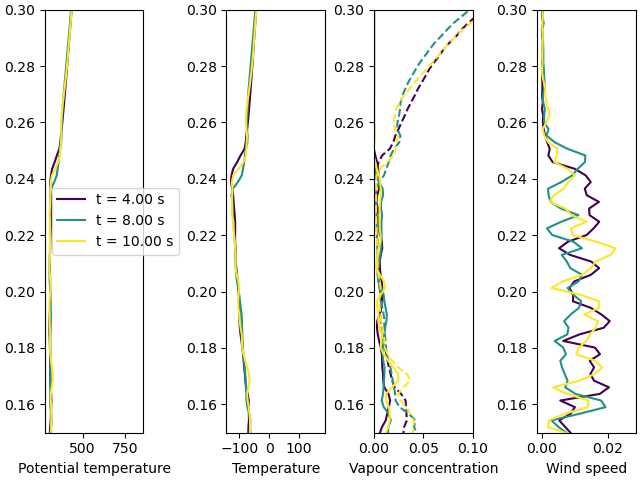

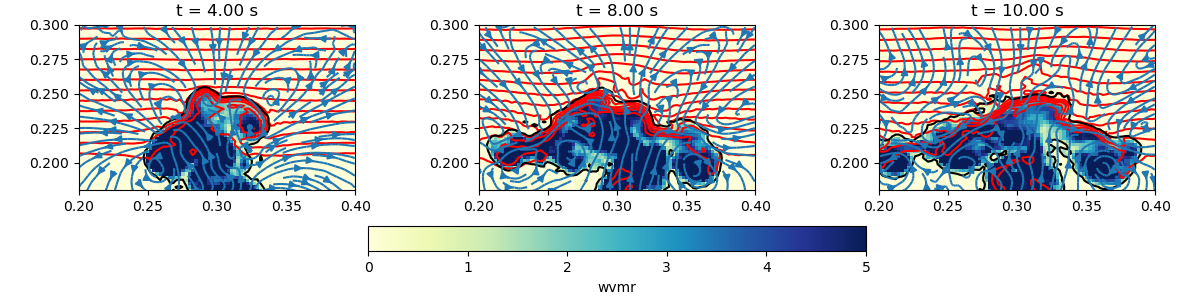

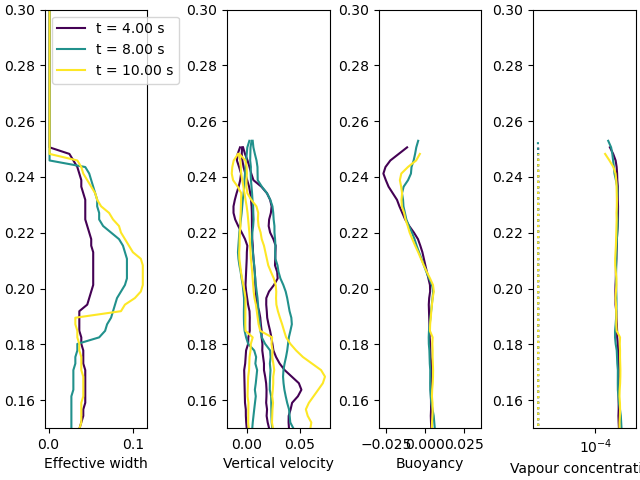

In [7]:
fig_xz, ax_xz = plt.subplots(1,len(steps), constrained_layout=True, figsize=(12,3))

fig, ax = plt.subplots(1, 4, constrained_layout=True)

fig_p, ax_p = plt.subplots(1, 4, constrained_layout=True)

cols = plt.cm.viridis(np.linspace(0, 1, len(steps)))
for i,c in zip(range(len(steps)), cols):
    wvmr_im = ax_xz[i].pcolormesh(X, Y, r[steps[i]], cmap='YlGnBu')
    wvmr_im.set_clim(0, 5)
    theta_contour = ax_xz[i].contour(Xf, Yf, theta[steps[i]], colors='r', levels=contours_b)
    cloud_contour = ax_xz[i].contour(Xf, Yf, phi_t[steps[i]], colors='k', levels=[5e-4])
    flow = ax_xz[i].streamplot(Xfi[::fnc, ::fnc], Yfi[::fnc, ::fnc], ui[steps[i], ::fnc, ::fnc], wi[steps[i], ::fnc, ::fnc], 
                               broken_streamlines=True, density=1, minlength=0.1)#, maxlength=0.1)

    ax_xz[i].set_xlim(0.2, 0.4)
    ax_xz[i].set_ylim(0.9*md['H'], 1.5*md['H'])
    ax_xz[i].set_aspect(1)

    ax_xz[i].set_title("t = {0:.2f} s".format(times[steps[i]]))

    if i == 0:
        wvmr_cbar = fig_xz.colorbar(wvmr_im, label="wvmr", ax=ax_xz[:], location='bottom', shrink=0.7)

    #####
    # TODO try these as averages rather than vertical profiles

    ax_p[0].plot(theta[steps[i], :, int(md['Nx']/2)], gzf, color=c, label="t = {0:.2f} s".format(times[steps[i]]))

    ax_p[1].plot(T[steps[i], :, int(md['Nx']/2)], gzf, color=c)

    ax_p[2].plot(phi_v[steps[i], :, int(md['Nx']/2)], gzf, color=c)
    ax_p[2].plot(np.exp(alpha/1340 * T[steps[i], :, int(md['Nx']/2)]), gzf, ls='--', color=c)
    ax_p[2].set_xlim(0,.1)

    ax_p[3].plot(np.sqrt(u[steps[i], :, int(md['Nx']/2)]**2 + v[steps[i], :, int(md['Nx']/2)]**2), gzf, color=c)

    #####

    ew = []
    cloud = np.where((phic_az[steps[i]] + phiv_az[steps[i]]) < 5e-4, 0, 1)
    for j in range(md['Nz']):
        ew.append(r_points[np.min(np.argwhere(cloud[j] < 1))])

    ax[0].plot(ew, gzf, label="t = {0:.2f} s".format(times[steps[i]]), color=c)

    ax[1].plot(np.nanmean(np.where(cloud == 1, w_az[steps[i]], np.nan), axis=1), gzf, color=c)
    ax[1].plot(np.nanmax(np.where(cloud == 1, w_az[steps[i]], np.nan), axis=1), gzf, color=c)
    ax[1].plot(np.nanmin(np.where(cloud == 1, w_az[steps[i]], np.nan), axis=1), gzf, color=c)

    ax[2].plot(np.nanmean(np.where(cloud == 1, b_az[steps[i]]-b_az_env, np.nan), axis=1), gzf, color=c)

    ax[3].plot(np.nanmean(np.where(cloud == 1, phiv_az[steps[i]], np.nan), axis=1), gzf, color=c)
    ax[3].plot(np.nanmean(np.where(cloud == 1, phic_az[steps[i]], np.nan), axis=1), gzf, color=c, ls=':')
    ax[3].set_xscale('log')
    #ax[3].plot(np.nanmean(np.where(cloud == 1, phi_az[steps[i]], np.nan)))

ax_p[0].set_xlabel("Potential temperature")
ax_p[1].set_xlabel("Temperature")
ax_p[2].set_xlabel("Vapour concentration")
ax_p[3].set_xlabel("Wind speed")

ax_p[0].legend()
ax[0].legend()

ax[0].set_xlabel("Effective width")
ax[1].set_xlabel("Vertical velocity")
ax[2].set_xlabel("Buoyancy")
ax[3].set_xlabel("Vapour concentration")

for a in ax:
    a.set_ylim(0.15, 0.3)
    
for a in ax_p:
    a.set_ylim(0.15, 0.3)

plt.show()